In [1]:
from keras.datasets import mnist
import numpy as np


Using TensorFlow backend.


In [50]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage
from scipy import misc
import cv2

In [59]:
import gzip
import pickle

def unpickle(file):
    import cPickle
    with open('data/cifar-10-batches-py/'+file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

In [83]:
data_batch = unpickle('data_batch_2')

In [84]:
data_batch

{'batch_label': 'training batch 2 of 5',
 'data': array([[ 35,  27,  25, ..., 169, 168, 168],
        [ 20,  20,  18, ..., 111,  97,  51],
        [116, 115, 155, ...,  18,  84, 124],
        ..., 
        [127, 139, 155, ..., 197, 192, 191],
        [190, 200, 208, ..., 163, 182, 192],
        [177, 174, 182, ..., 119, 127, 136]], dtype=uint8),
 'filenames': ['auto_s_000241.png',
  'bufo_viridis_s_001109.png',
  'rana_catesbeiana_s_000111.png',
  'banana_boat_s_000728.png',
  'powerboat_s_001487.png',
  'felis_catus_s_001376.png',
  'wapiti_s_001127.png',
  'goliath_frog_s_000230.png',
  'stealth_fighter_s_000898.png',
  'bullfrog_s_001623.png',
  'stealth_fighter_s_001883.png',
  'mouser_s_001482.png',
  'bufo_marinus_s_001427.png',
  'grass_frog_s_000425.png',
  'puppy_s_002462.png',
  'cervus_elaphus_s_001192.png',
  'cargo_ship_s_000773.png',
  'mouser_s_000261.png',
  'dunnock_s_000201.png',
  'western_toad_s_000205.png',
  'monoplane_s_001332.png',
  'felis_catus_s_000759.png',


In [246]:
#preprocessing
x_train = np.reshape(data_batch['data'], (10000, 3, 32, 32))
x_test = np.reshape(test_batch['data'], (10000, 3, 32, 32))
print x_test.shape
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


(10000, 3, 32, 32)


In [247]:
train_x=np.empty((10000,32,32))
test_x=np.empty((10000,32,32))
for i in range(x_train.shape[0]):
    train_x[i]= (0.2989*x_train[i][0]+0.5870*x_train[i][1]+0.1140*x_train[i][2])

for i in range(x_train.shape[0]):
    test_x[i]= (0.2989*x_test[i][0]+0.5870*x_test[i][1]+0.1140*x_test[i][2])


In [248]:

train_x=np.reshape(train_x,(10000,32,32,1)) 
test_x=np.reshape(test_x,(10000,32,32,1)) 


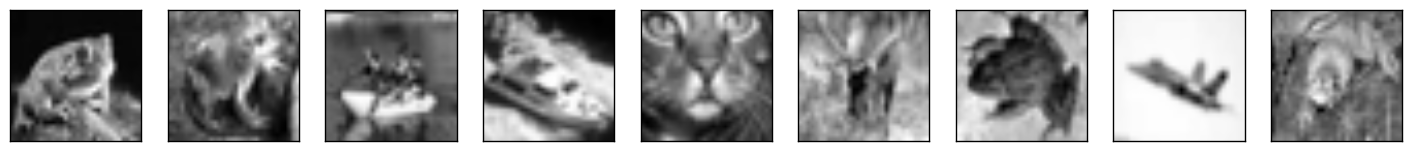

In [249]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)

    plt.imshow(train_x[i].reshape(32,32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [250]:
#adding noise
def salt_and_pepper(x_train,x_test,factor):
    noise_factor = factor
    
    x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
    x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

    #x_train_noisy = np.clip(x_train_noisy, 0, 255)
    #x_test_noisy = np.clip(x_test_noisy, 0., )
    
    return x_train_noisy,x_test_noisy

In [251]:
def gaussian_noise(x_train,x_test,sigma):
    row,col,ch= x_train[0].shape
    
    x_train_noisy = skimage.util.random_noise(x_train, mode='gaussian', seed=None, clip=True, mean=0, var=sigma**2)

    x_test_noisy = skimage.util.random_noise(x_test, mode='gaussian', seed=None, clip=True, mean=0, var=sigma**2)

    
    
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    
    return x_train_noisy,x_test_noisy

In [252]:
print x_train_noisy[0].shape

(32, 32, 1)


In [270]:
x_train_noisy,x_test_noisy = salt_and_pepper(train_x,test_x,0.01)

In [93]:
x_test_noisy.shape

(10000, 3, 32, 32)

In [244]:
x_train_noisy,x_test_noisy = gaussian_noise(train_x,test_x,1)

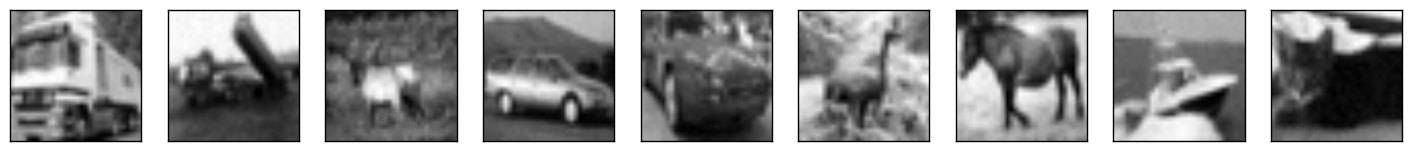

In [271]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(32,32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [272]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard


In [273]:
input_img = Input(shape=x_train_noisy[0].shape)  # adapt this if using `channels_first` image data format
print x_train_noisy[0].shape
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2 , 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

print autoencoder.summary()

(32, 32, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 8, 8, 32)          9248      
_________________________________________________________________
up_sampling2d_42 (UpSampling (None, 16, 16, 32)        0        

In [ ]:

autoencoder.fit(x_train_noisy, train_x,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, test_x),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
 3968/10000 [==========>...................] - ETA: 23s - loss: 0.6180

In [275]:
out = autoencoder.predict(x_test_noisy[0:11],verbose=1)
print out.shape

11/11 [==============================] - 0s
(11, 32, 32, 1)


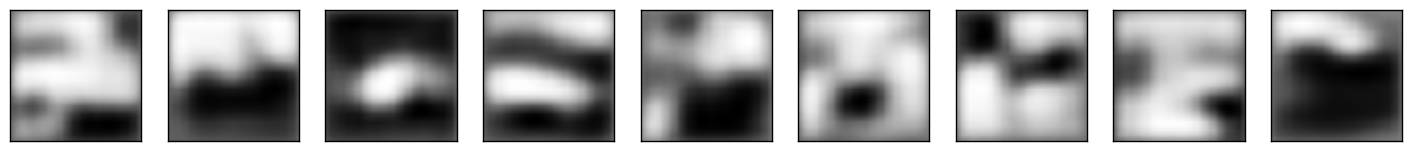

In [276]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(out[i].reshape(32,32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [69]:
import cv2

In [108]:
test_image = cv2.imread('data/two',0)

In [109]:
test_image = cv2.resize(test_image,(28,28))
test_image = np.expand_dims(test_image, axis=2)

In [110]:
test_image = skimage.util.random_noise(test_image, mode='gaussian', seed=None, clip=True, mean=0, var=0.5**0.5)

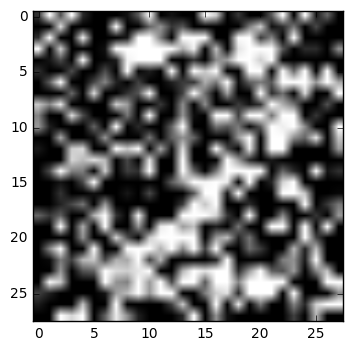

In [112]:
plt.imshow(test_image.reshape(28,28))
plt.show()

In [123]:
test=np.empty([1,28,28,1])
test[0]=test_image
pred = autoencoder.predict(test,verbose=1)

1/1 [==============================] - 0s


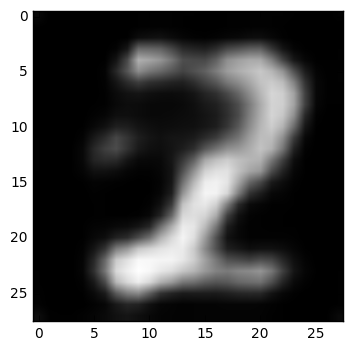

In [125]:
plt.imshow(pred.reshape(28,28))
plt.show()